In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import glob
from PIL import Image
import torch.nn as nn
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celebahq-resized-256x256' dataset.
Path to dataset files: /kaggle/input/celebahq-resized-256x256


In [ ]:
!ls /root/.cache/kagglehub/datasets/badasstechie/celebahq-resized-256x256/versions/1

ls: cannot access '/root/.cache/kagglehub/datasets/badasstechie/celebahq-resized-256x256/versions/1': No such file or directory


In [ ]:
import pandas as pd

img_dir_path = os.path.join(path,"celeba_hq_256")
imgs = os.listdir(os.path.join(path,"celeba_hq_256"))
df = pd.DataFrame(imgs,columns=['filename'])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df,test_size=0.2,random_state=31,shuffle=True)

In [ ]:
train_df.head()

,filename
9433,10694.jpg
9061,27082.jpg
14482,12897.jpg
17474,27926.jpg
141,16976.jpg


In [ ]:
class vae_dataset(Dataset):

  def __init__(self,data_path,df):
    self.data_path = data_path
    self.df = df



  def __len__(self):
    return len(self.df)


  def __getitem__(self,idx):

    row = self.df.iloc[idx]
    img_pth = os.path.join(self.data_path,row['filename'])
    img = Image.open(img_pth)

    img = img.convert('RGB')

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
    ])

    img = transform(img)

    return img

In [ ]:

train_ds = vae_dataset(data_path=img_dir_path,df=train_df)

In [ ]:
img = train_ds.__getitem__(2)

In [ ]:
img.shape

torch.Size([3, 256, 256])

In [ ]:
class denzi_encoder(nn.Module):

  def __init__(self,latent_dim = 256):
    super().__init__()
    self.latent_dim = latent_dim

    self.conv1 = nn.Sequential(
        nn.Conv2d(3,16,kernel_size=4,padding=1,stride=2),#128x128x64
        nn.BatchNorm2d(16),
        nn.LeakyReLU()

    )

    self.conv2 = nn.Sequential(
         nn.Conv2d(16,32,kernel_size=4,padding=1,stride=2),#64x64x128
         nn.BatchNorm2d(32),
        nn.LeakyReLU()
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=4,padding=1,stride=2),#32x32x256
        nn.BatchNorm2d(64),
        nn.LeakyReLU()
    )

    self.conv4 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2),#16x16x512
        nn.BatchNorm2d(128),
        nn.LeakyReLU()
    )

    self.conv5 = nn.Sequential(
        nn.Conv2d(128,256,kernel_size=4,padding=1,stride=2),#16x16x512
        nn.BatchNorm2d(256),
        nn.LeakyReLU()
    )

    self.conv6 = nn.Sequential(
        nn.Conv2d(256,256,kernel_size=4,padding=1,stride=2),#16x16x512
        nn.LeakyReLU()
    )

    self.flatten = nn.Flatten()

    self.fc_mu = nn.Linear(256*4*4,self.latent_dim)
    self.fc_logvar = nn.Linear(256*4*4,self.latent_dim)

  def forward(self,x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.flatten(x)

      mu = self.fc_mu(x)
      logvar = self.fc_logvar(x)# bu negatif olabilir. ama var negatif olamaz. linear layer çıktısı negatif olabileceği için logvar öğrenilir.
      logvar = torch.clamp(logvar,min=-8,max=8)

      return mu, logvar




In [ ]:
class denzi_decoder(nn.Module):
  def __init__(self,latent_dim = 256):
    super().__init__()

    self.latent_dim = latent_dim


    self.linear = nn.Sequential(
        nn.Linear(self.latent_dim,256 * 4 * 4),

        nn.LeakyReLU()
    )

    self.transpose_conv1 = nn.Sequential(
        nn.ConvTranspose2d(256,256,kernel_size=4,padding=1,stride=2),#8x8
        nn.BatchNorm2d(256),
        nn.LeakyReLU()

    )

    self.transpose_conv2 = nn.Sequential(
        nn.ConvTranspose2d(256,128,kernel_size=4,padding=1,stride=2),#16x16
        nn.BatchNorm2d(128),
        nn.LeakyReLU()
    )

    self.transpose_conv3 = nn.Sequential(
        nn.ConvTranspose2d(128,64,kernel_size=4,padding=1,stride=2),#32x32
        nn.BatchNorm2d(64),
        nn.LeakyReLU()
    )


    self.transpose_conv4 = nn.Sequential(
    nn.ConvTranspose2d(64,32,kernel_size=4,padding=1,stride=2),#64x64
    nn.BatchNorm2d(32),
    nn.LeakyReLU()
    )

    self.transpose_conv5 = nn.Sequential(
    nn.ConvTranspose2d(32,16,kernel_size=4,padding=1,stride=2),#128x128
    nn.BatchNorm2d(16),
    nn.LeakyReLU()
    )

    self.transpose_conv6 = nn.ConvTranspose2d(16,3,kernel_size=4,padding=1,stride=2)#256x256
    self.tanh = nn.Tanh()


  def forward(self,z):
    batch_size = z.shape[0]
    x = self.linear(z)#(B,1,512*4*4) buları değiiştirmek lazım
    x = torch.reshape(x,(batch_size,256,4,4))
    x = self.transpose_conv1(x)#256 8 8
    x = self.transpose_conv2(x)#128 16 16
    x = self.transpose_conv3(x)#64 32 32
    x = self.transpose_conv4(x)#32 64 64
    x = self.transpose_conv5(x)#32 64 64
    x = self.transpose_conv6(x)#32 64 64

    out = self.tanh(x)

    return out

In [ ]:


class denzi_vae(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = denzi_encoder(latent_dim=256)
    self.decoder = denzi_decoder(latent_dim=256)

  def reparameterize(self,mu,logvar):

      std = torch.exp(0.5 * logvar)

      epsilon = torch.randn_like(std)

      z = mu + std * epsilon

      return z

  def forward(self,x):

    mu, logvar = self.encoder(x)

    z = self.reparameterize(mu,logvar)

    out = self.decoder(z)


    return out, mu, logvar

In [ ]:
class cfg:
  BATCH_SIZE = 128
  VAL_BATCH_SIZE = 32
  LR = 1e-5
  EPOCH = 100

In [ ]:
class cfg:
  BATCH_SIZE = 128
  VAL_BATCH_SIZE = 32
  LR = 1e-5
  EPOCH = 100


train_ds = vae_dataset(data_path=img_dir_path,df=train_df)
val_ds = vae_dataset(data_path=img_dir_path,df = val_df)

train_loader = DataLoader(train_ds,batch_size=cfg.BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=cfg.VAL_BATCH_SIZE)

In [ ]:
def beta_scheduler(start_epoch,epoch, total_epochs, warmup_ratio=0.5):
    warmup_epochs = int((total_epochs-start_epoch) * warmup_ratio)

    if epoch>start_epoch:
      beta = 0.0005*(epoch-start_epoch)/warmup_epochs
    else:
      beta = 0

    beta = min(0.0005, beta)
    return beta


In [ ]:
def loss_func(output, target, mu, logvar, beta):

    recon_loss = torch.mean((output - target) ** 2)# burda mean almakla bunun farkı gerçekten var mı



    # 1) sample başına KL
    kl_per_sample = torch.sum(
        0.5*(mu**2 + torch.exp(logvar) - logvar - 1),
        dim=1
    )

    # 2) free bits
    free_bits = 0.5   # burayı sonra oynarız

    kl_clamped = torch.clamp(kl_per_sample, min=free_bits)

    # 3) mean
    kl_loss = kl_clamped.mean()

    # 4) beta
    kl_loss = beta * kl_loss

    loss = recon_loss + kl_loss

    return loss, recon_loss, kl_loss


In [ ]:
from tqdm import tqdm

model = denzi_vae()
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg.LR
)

# Learning rate scheduling parameters
start_lr = 1e-4
end_lr = 1e-5
start_decay_epoch = 30
end_decay_epoch = 100

for epoch in range(cfg.EPOCH):
  print(f"Epoch: {epoch+1}")

  # Learning rate scheduler
  if epoch + 1 >= start_decay_epoch and epoch + 1 <= end_decay_epoch:
    current_lr = start_lr - (start_lr - end_lr) * ((epoch + 1 - start_decay_epoch) / (end_decay_epoch - start_decay_epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr
    print(f"  Adjusted learning rate to: {current_lr:.6f}")
  elif epoch + 1 > end_decay_epoch:
    for param_group in optimizer.param_groups:
        param_group['lr'] = end_lr
    print(f"  Learning rate capped at: {end_lr:.6f}")

  model.train()

  epoch_losses = []
  epoch_recon_losses = []
  epoch_kl_losses = []
  epoch_p_losses = []

  for data in tqdm(train_loader):

    optimizer.zero_grad()

    data = data.to(device)

    output, mu, logvar = model(data)

    beta=beta_scheduler(5,epoch+1,cfg.EPOCH)

    loss, recon_loss, kl_loss = loss_func(output,data,mu,logvar,beta)
    epoch_losses.append(loss.item())
    epoch_recon_losses.append(recon_loss.item())
    epoch_kl_losses.append(kl_loss.item())


    loss.backward()

    optimizer.step()

  avg_epoch_loss = np.mean(np.asarray(epoch_losses))
  avg_epoch_recon_loss = np.mean(np.asarray(epoch_recon_losses))
  avg_epoch_kl_loss = np.mean(np.asarray(epoch_kl_losses))


  print(f"Epoch {epoch+1} - Train Loss: {avg_epoch_loss:.4f}, Recon Loss: {avg_epoch_recon_loss:.4f}, KL Loss: {avg_epoch_kl_loss:.4f}")

  # Log losses to Weights & Biases

Epoch: 1


100%|██████████| 188/188 [02:03<00:00,  1.52it/s]


Epoch 1 - Train Loss: 0.3829, Recon Loss: 0.3829, KL Loss: 0.0000
Epoch: 2


100%|██████████| 188/188 [00:50<00:00,  3.73it/s]


Epoch 2 - Train Loss: 0.2913, Recon Loss: 0.2913, KL Loss: 0.0000
Epoch: 3


100%|██████████| 188/188 [00:50<00:00,  3.73it/s]


Epoch 3 - Train Loss: 0.2168, Recon Loss: 0.2168, KL Loss: 0.0000
Epoch: 4


100%|██████████| 188/188 [00:50<00:00,  3.76it/s]


Epoch 4 - Train Loss: 0.1726, Recon Loss: 0.1726, KL Loss: 0.0000
Epoch: 5


100%|██████████| 188/188 [00:49<00:00,  3.77it/s]


Epoch 5 - Train Loss: 0.1444, Recon Loss: 0.1444, KL Loss: 0.0000
Epoch: 6


100%|██████████| 188/188 [00:49<00:00,  3.77it/s]


Epoch 6 - Train Loss: 0.1330, Recon Loss: 0.1262, KL Loss: 0.0068
Epoch: 7


100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


Epoch 7 - Train Loss: 0.1241, Recon Loss: 0.1145, KL Loss: 0.0096
Epoch: 8


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 8 - Train Loss: 0.1178, Recon Loss: 0.1062, KL Loss: 0.0116
Epoch: 9


100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


Epoch 9 - Train Loss: 0.1129, Recon Loss: 0.1001, KL Loss: 0.0128
Epoch: 10


100%|██████████| 188/188 [00:50<00:00,  3.72it/s]


Epoch 10 - Train Loss: 0.1089, Recon Loss: 0.0954, KL Loss: 0.0135
Epoch: 11


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 11 - Train Loss: 0.1058, Recon Loss: 0.0918, KL Loss: 0.0140
Epoch: 12


100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


Epoch 12 - Train Loss: 0.1033, Recon Loss: 0.0888, KL Loss: 0.0146
Epoch: 13


100%|██████████| 188/188 [00:50<00:00,  3.73it/s]


Epoch 13 - Train Loss: 0.1013, Recon Loss: 0.0862, KL Loss: 0.0151
Epoch: 14


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 14 - Train Loss: 0.0997, Recon Loss: 0.0839, KL Loss: 0.0157
Epoch: 15


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 15 - Train Loss: 0.0984, Recon Loss: 0.0820, KL Loss: 0.0164
Epoch: 16


100%|██████████| 188/188 [00:49<00:00,  3.76it/s]


Epoch 16 - Train Loss: 0.0975, Recon Loss: 0.0804, KL Loss: 0.0170
Epoch: 17


100%|██████████| 188/188 [00:49<00:00,  3.77it/s]


Epoch 17 - Train Loss: 0.0968, Recon Loss: 0.0791, KL Loss: 0.0177
Epoch: 18


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 18 - Train Loss: 0.0962, Recon Loss: 0.0779, KL Loss: 0.0183
Epoch: 19


100%|██████████| 188/188 [00:50<00:00,  3.76it/s]


Epoch 19 - Train Loss: 0.0959, Recon Loss: 0.0771, KL Loss: 0.0189
Epoch: 20


100%|██████████| 188/188 [00:49<00:00,  3.77it/s]


Epoch 20 - Train Loss: 0.0958, Recon Loss: 0.0763, KL Loss: 0.0194
Epoch: 21


100%|██████████| 188/188 [00:49<00:00,  3.78it/s]


Epoch 21 - Train Loss: 0.0957, Recon Loss: 0.0757, KL Loss: 0.0200
Epoch: 22


100%|██████████| 188/188 [00:50<00:00,  3.76it/s]


Epoch 22 - Train Loss: 0.0958, Recon Loss: 0.0754, KL Loss: 0.0205
Epoch: 23


100%|██████████| 188/188 [00:49<00:00,  3.76it/s]


Epoch 23 - Train Loss: 0.0960, Recon Loss: 0.0751, KL Loss: 0.0209
Epoch: 24


100%|██████████| 188/188 [00:49<00:00,  3.77it/s]


Epoch 24 - Train Loss: 0.0962, Recon Loss: 0.0748, KL Loss: 0.0214
Epoch: 25


100%|██████████| 188/188 [00:49<00:00,  3.77it/s]


Epoch 25 - Train Loss: 0.0964, Recon Loss: 0.0747, KL Loss: 0.0217
Epoch: 26


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 26 - Train Loss: 0.0968, Recon Loss: 0.0746, KL Loss: 0.0222
Epoch: 27


100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


Epoch 27 - Train Loss: 0.0971, Recon Loss: 0.0746, KL Loss: 0.0225
Epoch: 28


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 28 - Train Loss: 0.0974, Recon Loss: 0.0745, KL Loss: 0.0229
Epoch: 29


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 29 - Train Loss: 0.0977, Recon Loss: 0.0746, KL Loss: 0.0232
Epoch: 30
  Adjusted learning rate to: 0.000100


100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


Epoch 30 - Train Loss: 0.0990, Recon Loss: 0.0758, KL Loss: 0.0232
Epoch: 31
  Adjusted learning rate to: 0.000099


100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


Epoch 31 - Train Loss: 0.0944, Recon Loss: 0.0717, KL Loss: 0.0228
Epoch: 32
  Adjusted learning rate to: 0.000097


100%|██████████| 188/188 [00:50<00:00,  3.72it/s]


Epoch 32 - Train Loss: 0.0912, Recon Loss: 0.0687, KL Loss: 0.0225
Epoch: 33
  Adjusted learning rate to: 0.000096


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 33 - Train Loss: 0.0889, Recon Loss: 0.0666, KL Loss: 0.0223
Epoch: 34
  Adjusted learning rate to: 0.000095


100%|██████████| 188/188 [00:50<00:00,  3.73it/s]


Epoch 34 - Train Loss: 0.0873, Recon Loss: 0.0652, KL Loss: 0.0221
Epoch: 35
  Adjusted learning rate to: 0.000094


100%|██████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 35 - Train Loss: 0.0862, Recon Loss: 0.0642, KL Loss: 0.0220
Epoch: 36
  Adjusted learning rate to: 0.000092


100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


Epoch 36 - Train Loss: 0.0852, Recon Loss: 0.0632, KL Loss: 0.0220
Epoch: 37
  Adjusted learning rate to: 0.000091


100%|██████████| 188/188 [00:50<00:00,  3.73it/s]


Epoch 37 - Train Loss: 0.0847, Recon Loss: 0.0627, KL Loss: 0.0220
Epoch: 38
  Adjusted learning rate to: 0.000090


100%|██████████| 188/188 [00:50<00:00,  3.71it/s]


Epoch 38 - Train Loss: 0.0840, Recon Loss: 0.0620, KL Loss: 0.0221
Epoch: 39
  Adjusted learning rate to: 0.000088


100%|██████████| 188/188 [00:50<00:00,  3.72it/s]


Epoch 39 - Train Loss: 0.0838, Recon Loss: 0.0616, KL Loss: 0.0222
Epoch: 40
  Adjusted learning rate to: 0.000087


100%|██████████| 188/188 [00:51<00:00,  3.67it/s]


Epoch 40 - Train Loss: 0.0835, Recon Loss: 0.0612, KL Loss: 0.0223
Epoch: 41
  Adjusted learning rate to: 0.000086


100%|██████████| 188/188 [00:51<00:00,  3.63it/s]


Epoch 41 - Train Loss: 0.0832, Recon Loss: 0.0608, KL Loss: 0.0224
Epoch: 42
  Adjusted learning rate to: 0.000085


100%|██████████| 188/188 [00:51<00:00,  3.63it/s]


Epoch 42 - Train Loss: 0.0831, Recon Loss: 0.0605, KL Loss: 0.0226
Epoch: 43
  Adjusted learning rate to: 0.000083


100%|██████████| 188/188 [00:51<00:00,  3.66it/s]


Epoch 43 - Train Loss: 0.0832, Recon Loss: 0.0605, KL Loss: 0.0227
Epoch: 44
  Adjusted learning rate to: 0.000082


100%|██████████| 188/188 [00:51<00:00,  3.64it/s]


Epoch 44 - Train Loss: 0.0831, Recon Loss: 0.0602, KL Loss: 0.0229
Epoch: 45
  Adjusted learning rate to: 0.000081


100%|██████████| 188/188 [00:52<00:00,  3.61it/s]


Epoch 45 - Train Loss: 0.0833, Recon Loss: 0.0602, KL Loss: 0.0231
Epoch: 46
  Adjusted learning rate to: 0.000079


100%|██████████| 188/188 [00:51<00:00,  3.63it/s]


Epoch 46 - Train Loss: 0.0832, Recon Loss: 0.0600, KL Loss: 0.0232
Epoch: 47
  Adjusted learning rate to: 0.000078


100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


Epoch 47 - Train Loss: 0.0834, Recon Loss: 0.0600, KL Loss: 0.0234
Epoch: 48
  Adjusted learning rate to: 0.000077


100%|██████████| 188/188 [00:51<00:00,  3.65it/s]


Epoch 48 - Train Loss: 0.0835, Recon Loss: 0.0599, KL Loss: 0.0235
Epoch: 49
  Adjusted learning rate to: 0.000076


100%|██████████| 188/188 [00:51<00:00,  3.64it/s]


Epoch 49 - Train Loss: 0.0835, Recon Loss: 0.0598, KL Loss: 0.0237
Epoch: 50
  Adjusted learning rate to: 0.000074


100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


Epoch 50 - Train Loss: 0.0837, Recon Loss: 0.0598, KL Loss: 0.0239
Epoch: 51
  Adjusted learning rate to: 0.000073


100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


Epoch 51 - Train Loss: 0.0840, Recon Loss: 0.0601, KL Loss: 0.0240
Epoch: 52
  Adjusted learning rate to: 0.000072


100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


Epoch 52 - Train Loss: 0.0842, Recon Loss: 0.0600, KL Loss: 0.0242
Epoch: 53
  Adjusted learning rate to: 0.000070


100%|██████████| 188/188 [00:51<00:00,  3.65it/s]


Epoch 53 - Train Loss: 0.0838, Recon Loss: 0.0597, KL Loss: 0.0241
Epoch: 54
  Adjusted learning rate to: 0.000069


100%|██████████| 188/188 [00:53<00:00,  3.54it/s]


Epoch 54 - Train Loss: 0.0836, Recon Loss: 0.0596, KL Loss: 0.0240
Epoch: 55
  Adjusted learning rate to: 0.000068


100%|██████████| 188/188 [00:52<00:00,  3.61it/s]


Epoch 55 - Train Loss: 0.0833, Recon Loss: 0.0594, KL Loss: 0.0240
Epoch: 56
  Adjusted learning rate to: 0.000067


100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


Epoch 56 - Train Loss: 0.0831, Recon Loss: 0.0591, KL Loss: 0.0239
Epoch: 57
  Adjusted learning rate to: 0.000065


100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


Epoch 57 - Train Loss: 0.0829, Recon Loss: 0.0591, KL Loss: 0.0239
Epoch: 58
  Adjusted learning rate to: 0.000064


100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


Epoch 58 - Train Loss: 0.0827, Recon Loss: 0.0589, KL Loss: 0.0238
Epoch: 59
  Adjusted learning rate to: 0.000063


100%|██████████| 188/188 [00:51<00:00,  3.64it/s]


Epoch 59 - Train Loss: 0.0824, Recon Loss: 0.0586, KL Loss: 0.0238
Epoch: 60
  Adjusted learning rate to: 0.000061


 20%|██        | 38/188 [00:10<00:40,  3.68it/s]


KeyboardInterrupt: 

Before saving to Google Drive, you need to mount it to your Colab environment. This will prompt you to authenticate your Google account.

Now that your Google Drive is mounted, you can save the `model` to a specified path in your Drive.

In [ ]:
import torch
import os

# Define the path where you want to save the model in your Google Drive
save_path = '/content/drive/MyDrive/a.pth' # You can change the filename and path

# Ensure the directory exists (if saving to a subfolder)
# For example, if you want to save to '/content/drive/MyDrive/my_models/vae_model.pth'
# os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model state dictionary
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/modelvae.pth


In [ ]:
inference_model = denzi_vae()
inference_model.load_state_dict(torch.load('/content/drive/MyDrive/modelvae.pth', weights_only=True))
inference_model.to(device)
inference_model.eval()

denzi_vae(
  (encoder): denzi_encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (conv3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (conv4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
  

In [ ]:
img = train_ds.__getitem__(0)

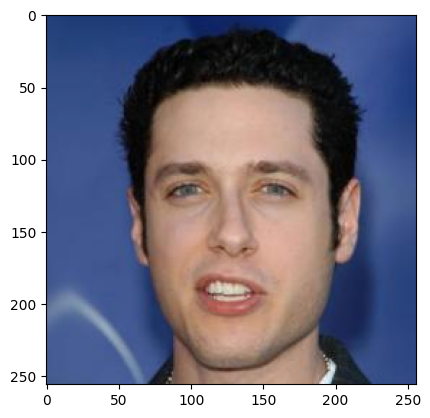

In [ ]:
plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)

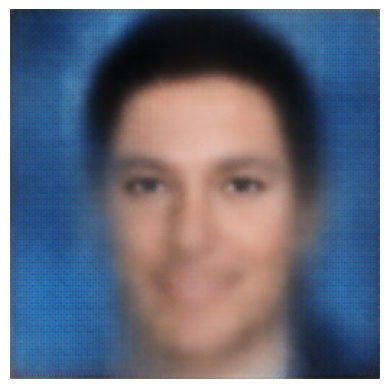

In [ ]:


with torch.no_grad():
    img = img.to(device)
    img = img.unsqueeze(0) # Add batch dimension for inference
    mu, logvar = inference_model.encoder(img)
    z = inference_model.reparameterize(mu,logvar)

    generated = inference_model.decoder(z)

generated =  (generated +1)/2

img = generated.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis("off")
plt.show()

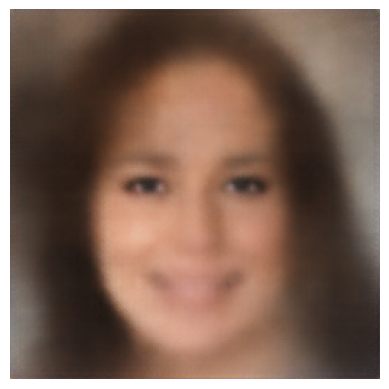

In [ ]:


import matplotlib.pyplot as plt

with torch.no_grad():
    z = torch.randn(1, 256).to(device)
    generated = inference_model.decoder(z)

generated =  (generated +1)/2

img = generated.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
import torch
import numpy as np
import imageio
from tqdm import tqdm

# --- AYARLAR ---
FPS = 30                # Akıcılık
TRANSITION_SEC = 2      # Her yüz arası geçiş süresi (saniye)
NUM_STOPS = 6           # Kaç farklı yüze uğrayacağız? (Durak sayısı)
LATENT_DIM = 256        # Senin modelinin boyutu

def generate_tour_video(model, filename='latent_tour.mp4'):
    print(f"Latent Gezi Başlıyor: {NUM_STOPS} farklı yüz ziyaret edilecek...")

    model.eval()
    frames = []

    # 1. Durakları Belirle (Rastgele 'z' noktaları)
    # (NUM_STOPS, 256) boyutunda bir tensor
    stops = torch.randn(NUM_STOPS, LATENT_DIM).to(device)

    # Son durağı ilk durakla aynı yapalım ki video "loop" olsun (başa dönsün)
    # İstersen bu satırı silebilirsin.
    stops = torch.cat([stops, stops[0:1]], dim=0)

    # 2. Her durak arasında yolculuk yap
    for i in range(len(stops) - 1):
        z_start = stops[i]
        z_end = stops[i+1]

        # Bu iki durak arasındaki adım sayısı
        n_frames = FPS * TRANSITION_SEC
        alphas = np.linspace(0, 1, n_frames)

        print(f"Geçiş {i+1}: Durak {i} -> Durak {i+1}")

        with torch.no_grad():
            for alpha in alphas:
                # Linear Interpolation
                z_current = (1 - alpha) * z_start + alpha * z_end

                # Batch boyutu ekle (1, 256)
                z_current = z_current.unsqueeze(0)

                # Decoder
                img_tensor = model.decoder(z_current)

                # Görüntü İşleme
                img = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
                img = (img + 1) / 2 # Denormalize
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)

                frames.append(img)

    # 3. Kaydet
    imageio.mimsave(filename, frames, fps=FPS)
    print(f"Gezi bitti! Video '{filename}' olarak kaydedildi.")

# --- ÇALIŞTIR ---
generate_tour_video(inference_model, filename='uzun_yuz_gezisi.mp4')

# İzlemek için
from IPython.display import Video
Video("uzun_yuz_gezisi.mp4", embed=True)

Latent Gezi Başlıyor: 6 farklı yüz ziyaret edilecek...
Geçiş 1: Durak 0 -> Durak 1
Geçiş 2: Durak 1 -> Durak 2
Geçiş 3: Durak 2 -> Durak 3
Geçiş 4: Durak 3 -> Durak 4
Geçiş 5: Durak 4 -> Durak 5
Geçiş 6: Durak 5 -> Durak 6
Gezi bitti! Video 'uzun_yuz_gezisi.mp4' olarak kaydedildi.
